# Visualize taxonomy and alpha/beta diversities

## Platform dependent part
- Resolve platform setup
- the difference to local imports should be resolved by setting the Blue Cloud VRE well, Colab will still be an issue.

In [1]:
import sys
import os
import io
import logging
from IPython import get_ipython
logger = logging.getLogger(name="Diversity analysis app")

if 'google.colab' in str(get_ipython()):
    # clone the momics-demos repository to use the utils module from there
    # TODO: eventually utils from momics will be used for that
    try:
        os.system('git clone https://github.com/palec87/momics-demos.git')
        logger.info(f"Repository cloned")
    except OSError as e:
        logger.info(f"An error occurred while cloning the repository: {e}")

    sys.path.insert(0,'/content/momics-demos')
elif "zmqshell" in str(get_ipython()):
    logger.info("Binder")
    print('binder')
    sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
else:
    logger.info("Local")
    print('local')
    sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))  # local utils, to be removed in the future

    # downside of this is that all the deps need to be installed in the current (momics-demos) environment
    # sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../../marine-omics')))  # local momics package, to be removed too

from utils import init_setup, get_notebook_environment
# Determine the notebook environment
env = get_notebook_environment()

init_setup()
logger.info(f"Environment: {env}")

# if path exists add sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../../marine-omics')))  # local momics package, to be removed too
local_momics_path = os.path.abspath(os.path.join(os.getcwd(), '../../../marine-omics'))
if os.path.exists(local_momics_path):
    sys.path.append(local_momics_path)
    logger.info(f"Added local momics path: {local_momics_path}")
    print(f"Added local momics path: {local_momics_path}")

binder
Platform: local Linux
Added local momics path: /media/davidp/Data/coding/marine_omics/marine-omics


## Imports

In [ ]:
# This needs to be repeated here for the Pannel dashboard to work, WEIRD
# TODO: report as possible bug
import sys
import os
import io
import warnings
import psutil


from functools import partial
warnings.filterwarnings('ignore')

# import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
import panel as pn
from dotenv import load_dotenv
load_dotenv()

from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa

# All low level functions are imported from the momics package
from momics.loader import load_parquets, process_collection_date, extract_season
import momics.plotting as pl
from momics.panel_utils import (
    diversity_select_widgets, create_indicators_diversity,
    serve_app, close_server,
)
from momics.utils import memory_load, reconfig_logger
from momics.taxonomy import (
    pivot_taxonomic_data,
    separate_taxonomy)

# Note: This is breaking the panel preview functionality
# %load_ext autoreload
# %autoreload 2

## User settings

In [3]:
DEBUG = True  # enable stdout logging

# Set up logging
reconfig_logger()

INFO | root | Logging.basicConfig completed successfully


## Loading

In [4]:
def fill_na_for_object_columns(df):
    """
    Fill NA values with 'NA' for object columns in the dataframe.

    Args:
        df (pd.DataFrame): The input dataframe.

    Returns:
        pd.DataFrame: The dataframe with NA values filled for object columns.
    """
    # Apply fillna only to object columns
    df[df.select_dtypes(include=['object']).columns] = df.select_dtypes(include=['object']).apply(lambda col: col.fillna('NA'))
    return df

@pn.cache()
def get_data(folder):
    return load_parquets(folder)

# @pn.cache()
def get_metadata(folder):
    # Load metadata
    sample_metadata = pd.read_csv(
        os.path.join(folder, "Batch1and2_combined_logsheets_2024-09-11.csv")
    )

    observatory_metadata = pd.read_csv(
        os.path.join(folder, "Observatory_combined_logsheets_validated.csv")
    )

    # Merge metadata
    full_metadata = pd.merge(
        sample_metadata,
        observatory_metadata,
        on=["obs_id", "env_package"],  # Matching conditions
        how="inner"  # Inner join
    )

    # Sort the merged dataframe by 'ref_code' column in ascending order
    full_metadata = full_metadata.sort_values(by="ref_code", ascending=True)

    # first convert some of the boolean cols
    full_metadata["failure"] = full_metadata["failure"].astype(str)
    # replace the 'nan' values with 'NA'
    full_metadata["failure"] = full_metadata["failure"].replace("nan", "NA")


    # adding replacement for the missing values for object type columns
    full_metadata = fill_na_for_object_columns(full_metadata)
    
    return full_metadata

In [5]:
# parquet files
if 'google.colab' in str(get_ipython()):
    root_folder = os.path.abspath(os.path.join('/content/momics-demos'))
else:
    root_folder = os.path.abspath(os.path.join('../'))


data_folder = os.path.join(root_folder, 'data/parquet_files')
assets_folder = os.path.join(root_folder, 'assets')


mgf_parquet_dfs = get_data(data_folder)

### Enhance matadata

In [ ]:
## TODO: enhace metadata here
# Load and merge metadata
full_metadata = get_metadata(os.path.join(root_folder, 'data'))
full_metadata = process_collection_date(full_metadata)
full_metadata = extract_season(full_metadata)

In [7]:


# select categorical columns from metadata
categorical_columns = sorted(full_metadata.select_dtypes(include=['object', "boolean"]).columns)
cat_to_remove = ["ref_code", "samp_description", "source_mat_id", "source_mat_id_orig"]
categorical_columns = [k for k in categorical_columns if k not in cat_to_remove]

# select numerical columns from metadata
numerical_columns = sorted(full_metadata.select_dtypes(include=['int64', 'float64']).columns)

assert (
    len(full_metadata.columns) == len(numerical_columns) + len(categorical_columns) + len(cat_to_remove), # + for removed cats
"i have wrong number orf columns in the metadata",
)

if DEBUG:
    logger.info(f"Data table names are:\n{mgf_parquet_dfs.keys()}")
    logger.info(f"Categorical metadata columns are:\n{categorical_columns}")
    logger.info(f"Numerical metadata columns are:\n{numerical_columns}")

INFO | Diversity analysis app | Data table names are:
dict_keys(['go', 'go_slim', 'ips', 'ko', 'LSU', 'pfam', 'SSU'])
INFO | Diversity analysis app | Categorical metadata columns are:
['ENA_accession_number_project', 'ENA_accession_number_umbrella', 'ammonium_method', 'arr_date_hq', 'arr_date_seq', 'chlorophyll_method', 'conduc_method', 'contact_email', 'contact_name', 'contact_orcid', 'density_method', 'diss_oxygen_method', 'env_broad_biome', 'env_local', 'env_material', 'env_package', 'extra_site_info', 'failure', 'failure_comment', 'geo_loc_name', 'investigation_type', 'loc_broad_ocean', 'loc_loc', 'loc_regional', 'long_store', 'month_name', 'nitrate_method', 'nitrite_method', 'obs_id', 'organism_count', 'organism_count_method', 'organization', 'organization_country', 'organization_edmoid', 'other_person', 'other_person_orcid', 'ph_method', 'phaeopigments_method', 'phosphate_method', 'pigments_method', 'pressure_method', 'project_name', 'samp_collect_device', 'samp_mat_process', 'sa

### Pivot the tables here

In [8]:
# LSU and SSU
lsu = mgf_parquet_dfs['LSU']
ssu = mgf_parquet_dfs['SSU']

lsu_standard = pivot_taxonomic_data(lsu)
ssu_standard = pivot_taxonomic_data(ssu)

In [9]:
ssu_standard.head(10)
# lsu_standard.index

,ncbi_tax_id,taxonomic_concat,EMOBON00001,EMOBON00003,EMOBON00004,EMOBON00005,EMOBON00006,EMOBON00007,EMOBON00008,EMOBON00009,...,EMOBON00242,EMOBON00243,EMOBON00244,EMOBON00245,EMOBON00246,EMOBON00247,EMOBON00248,EMOBON00249,EMOBON00250,EMOBON00251
0,2,2;sk_Bacteria;k_;p_;c_;o_;f_;g_;s_,0.134257,0.131661,0.165285,0.217925,0.214523,0.263303,0.246803,0.083184,...,0.131825,0.118200,0.226026,0.129445,0.232102,0.138737,0.203030,0.158843,0.197760,0.163707
1,6,6;sk_Bacteria;k_;p_Proteobacteria;c_Alphaprote...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,10,10;sk_Bacteria;k_;p_Proteobacteria;c_Gammaprot...,0.000000,0.000000,0.000000,0.000000,0.000000,0.004139,0.000000,0.000000,...,0.000000,0.000000,0.014175,0.007147,0.012030,0.007071,0.011084,0.010841,0.009364,0.013479
3,16,16;sk_Bacteria;k_;p_Proteobacteria;c_Betaprote...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,18,18;sk_Bacteria;k_;p_Proteobacteria;c_Deltaprot...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.009826,0.014814,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,20,20;sk_Bacteria;k_;p_Proteobacteria;c_Alphaprot...,0.000000,0.000000,0.000000,0.000000,0.000000,0.007170,0.008663,0.000000,...,0.000000,0.000000,0.000000,0.015982,0.008506,0.010000,0.013576,0.015332,0.006622,0.016509
6,22,22;sk_Bacteria;k_;p_Proteobacteria;c_Gammaprot...,0.042835,0.008986,0.008143,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.017019,0.008553,0.012276,0.007147,0.017013,0.012247,0.015676,0.000000,0.009364,0.000000
7,29,29;sk_Bacteria;k_;p_Proteobacteria;c_Deltaprot...,0.095783,0.008986,0.009973,0.015429,0.010733,0.089932,0.079210,0.005831,...,0.091911,0.095238,0.058446,0.026743,0.061341,0.018707,0.058127,0.023420,0.053793,0.026959
8,31,31;sk_Bacteria;k_;p_Proteobacteria;c_Deltaprot...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.006015,0.000000,0.000000,0.000000,0.000000,0.000000
9,39,39;sk_Bacteria;k_;p_Proteobacteria;c_Deltaprot...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [10]:
# this is used fot the tabular view only
df = mgf_parquet_dfs['SSU'].copy()
if DEBUG:
    logger.info(f'Number of unique ref_codes: {df.ref_code.nunique()}')

INFO | Diversity analysis app | Number of unique ref_codes: 181


## Development of the beta diversity part

In [11]:
# TODO: link these functions to the indicator
# TODO: put them in the momics package
def get_missing_taxa(df):
    for taxon in ["superkingdom", "kingdom", "phylum", "class", "order", "family", "genus", "species"]:
        logger.info(f'Not classified on {taxon}: {get_missing_taxa_single(df, taxon)}')
    return

def get_missing_taxa_single(df, taxon):
    return len(df[df[taxon].isnull()])

## Permanova calculation

### Extract from pivot tables

#### Methods

In [12]:
# Function to aggregate data by a specific taxonomic level
def aggregate_by_taxonomic_level(df, level):
    # Drop rows where the level is missing
    df_level = df.dropna(subset=[level])
    # Group by the specified level and sum abundances across samples (columns)
    df_grouped = df_level.groupby(level).sum(numeric_only=True)
    return df_grouped

def separate_taxonomy(df):
    eukaryota_keywords = ['Discoba', 'Stramenopiles', 'Rhizaria', 'Alveolata', 'Amorphea', 'Archaeoplastida', 'Excavata']

    # Separate rows based on "Bacteria", "Archaea", and "Eukaryota" entries
    prokaryotes_all = df[df.index.str.contains("Bacteria|Archaea", regex=True)]
    eukaryota_all = df[df.index.str.contains("Eukaryota", regex=True)]

    # Further divide "Prokaryotes all" into "Bacteria" and "Archaea"
    bacteria = prokaryotes_all[prokaryotes_all.index.str.contains("Bacteria")]
    archaea = prokaryotes_all[prokaryotes_all.index.str.contains("Archaea")]

    # Further divide "Eukaryota all" by specific keywords
    eukaryota_dict = {}
    for keyword in eukaryota_keywords:
        subset = eukaryota_all[eukaryota_all.index.str.contains(keyword)]
        eukaryota_dict[keyword] = subset
        # Standardize each column to sum to 100 before saving the CSV
        subset_normalized = subset.div(subset.sum(axis=0), axis=1) * 100

    # Apply taxonomy splitting to the index
    taxonomy_levels = bacteria.index.to_series().apply(split_taxonomy)
    taxonomy_df = pd.DataFrame(taxonomy_levels.tolist(), columns=['phylum', 'class', 'order', 'family', 'genus', 'species'],
                               index=bacteria.index)

    # Combine taxonomy with the abundance data
    bacteria_data = pd.concat([taxonomy_df, bacteria], axis=1)
    

    # Aggregate at each taxonomic level and save to CSV
    taxonomic_levels = ['phylum', 'class', 'order', 'family', 'genus']
    bacteria_levels_dict = {}
    for level in taxonomic_levels:
        aggregated_df = aggregate_by_taxonomic_level(bacteria_data, level)
        # Standardize the values so each column sums to 100
        aggregated_df_normalized = aggregated_df.div(aggregated_df.sum(axis=0), axis=1) * 100
        bacteria_levels_dict[f"Bacteria_{level}"] = aggregated_df_normalized

    all_data = {
        "Prokaryotes All": prokaryotes_all,
        "Eukaryota All": eukaryota_all,
        "Bacteria": bacteria,
        "Archaea": archaea
    }
    all_data.update(eukaryota_dict)
    all_data.update(bacteria_levels_dict)

    return all_data

def split_taxonomy(index_name):
    # Remove anything before "Bacteria" or "Archaea"
    if "Bacteria" in index_name:
        taxonomy = index_name.split("Bacteria;", 1)[1].split(";")
    elif "Archaea" in index_name:
        taxonomy = index_name.split("Archaea;", 1)[1].split(";")
    else:
        taxonomy = []
    # Return a list with taxonomic levels up to species
    return taxonomy[1:7]  # ['phylum', 'class', 'order', 'family', 'genus', 'species']

### Dropdowns for the pCOA as Andrzej

In [13]:
lsu_standard.head()

,ncbi_tax_id,taxonomic_concat,EMOBON00001,EMOBON00003,EMOBON00004,EMOBON00005,EMOBON00006,EMOBON00007,EMOBON00008,EMOBON00009,...,EMOBON00242,EMOBON00243,EMOBON00244,EMOBON00245,EMOBON00246,EMOBON00247,EMOBON00248,EMOBON00249,EMOBON00250,EMOBON00251
0,2,2;sk_Bacteria;k_;p_;c_;o_;f_;g_;s_,0.366504,0.187182,0.227603,0.225391,0.219082,0.363413,0.340867,0.053850,...,0.361056,0.352079,0.335658,0.191443,0.341322,0.18905,0.280487,0.209720,0.275366,0.206238
1,6,6;sk_Bacteria;k_;p_Proteobacteria;c_Alphaprote...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.004571,0.000000,0.004946
2,10,10;sk_Bacteria;k_;p_Proteobacteria;c_Gammaprot...,0.007395,0.000000,0.000000,0.000000,0.000000,0.003010,0.003971,0.004284,...,0.000000,0.000000,0.013024,0.007325,0.007712,0.00000,0.011679,0.000000,0.010854,0.009891
3,16,16;sk_Bacteria;k_;p_Proteobacteria;c_Betaprote...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.01016,0.000000,0.004571,0.000000,0.000000
4,18,18;sk_Bacteria;k_;p_Proteobacteria;c_Deltaprot...,0.010459,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.011643,0.000000,0.005317,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000


In [15]:
lsu_standard.set_index('taxonomic_concat', inplace=True)
ssu_standard.set_index('taxonomic_concat', inplace=True)

split_taxo_tables_lsu = separate_taxonomy(lsu_standard)
split_taxo_tables_ssu = separate_taxonomy(ssu_standard)

In [85]:
# for k, v in split_taxo_tables_lsu.items():
#     logger.info(f"Taxonomic level: {k}")
#     logger.info(f"DataFrame shape: {v.shape}")

In [117]:
pn.extension("tabulator")

granular_tables = {
    "LSU": split_taxo_tables_lsu,
    "SSU": split_taxo_tables_ssu
}

select_granular_table = pn.widgets.Select(
    name="Granular analysis",
    value="LSU",
    options= list(granular_tables.keys()),
    description="Select a table for granular analysis",
)

select_granular_level = pn.widgets.Select(
    name="Subset taxonomic level",
    value=list(granular_tables[select_granular_table.value].keys())[0],
    options=list(granular_tables[select_granular_table.value].keys()),
    description="Select a table for analysis",
)

factors_to_remove = ['ENA_accession_number_project', "ENA_accession_number_umbrella", "arr_date_hq",
                     "arr_date_seq", "contact_email", "contact_name", "contact_orcid",
                     "investigation_type", "long_store", "organism_count_method", "organization_edmoid",
                     'other_person', 'other_person_orcid',"organization_country", "project_name",
                     "samp_store_date", 'samp_mat_process', 'samp_mat_process_dev',
                     'samp_store_loc', 'sampl_person', 'sampl_person_orcid', 'store_person',
                     'store_person_orcid', 'time_fi', "wa_id",
                     'env_broad_biome', 'env_local', "extra_site_info", 'failure_comment',
                     'obs_id', 'size_frac','ship_date', 'ship_date_seq', 'sampling_event', 'organism_count',
                     'samp_collect_device',
                     'ammonium_method', 'chlorophyll_method', 'conduc_method', 'density_method', 'diss_oxygen_method',
                     'nitrate_method', 'nitrite_method', 'ph_method', 'phaeopigments_method', 'phosphate_method', 'pigments_method', 'pressure_method',
                     'sea_subsurf_salinity_method', 'sea_subsurf_temp_method', 'sea_surf_salinity_method', 'sea_surf_temp_method',
                     'silicate_method', 'turbidity_method']
factor_cols = [col for col in categorical_columns if col not in factors_to_remove]
pcoa_factor_dropdowns = {
    categorical_col: pn.widgets.MultiSelect(
        name=categorical_col,
        value=['All'],
        options=['All'] + list(full_metadata[categorical_col].unique()),
        size=8)
        for categorical_col in factor_cols
}
box_granular = pn.GridBox(*pcoa_factor_dropdowns.values(), ncols=4)

color_factor_granular = pn.widgets.Select(
    name="Color by",
    value=factor_cols[0],
    options=factor_cols,
    # description="Select a table for analysis",
)

symbol_factor_granular = pn.widgets.Select(
    name="Symbol by",
    value=factor_cols[1],
    options=factor_cols,
    # description="Select a table for analysis",
)


# Filter the metadata table based on the selections in box_granular
def filter_metadata_table(metadata_df, selected_factors):
    # Create a copy of the metadata DataFrame
    filtered_metadata = metadata_df.copy()
    # Apply filters for each selected factor
    for factor, selected_values in selected_factors.items():
        if 'All' not in selected_values:
            filtered_metadata = filtered_metadata[filtered_metadata[factor].isin(selected_values)]
    return filtered_metadata

def get_filtered_metadata():
    # Retrieve the selected factors from the dropdowns
    selected_factors = {col: pcoa_factor_dropdowns[col].value for col in factor_cols}
    # Filter the metadata table
    filtered_metadata = filter_metadata_table(full_metadata, selected_factors)
    return filtered_metadata


In [118]:
box_granular

BokehModel(combine_events=True, render_bundle={'docs_json': {'b58edee7-95a5-4137-8125-bbd551465fab': {'version…

In [145]:
## filter data according to the metadata
def filter_data(df, filtered_metadata):
    # Filter the DataFrame column names based on the 'ref_code' values in the filtered metadata

    # filter columns names of df which are in the filtered metadata
    cols_to_keep = list([col for col in df.columns.str.strip() if col in filtered_metadata['ref_code'].to_list()])

    filtered_df = df[cols_to_keep]
    return filtered_df

def filter_all_box_selection(df):
    # Retrieve the filtered metadata
    filtered_metadata = get_filtered_metadata()
    # Filter the data
    filtered_data = filter_data(df, filtered_metadata)
    return filtered_metadata, filtered_data


In [151]:
filtered_metadata, filtered_data = filter_all_box_selection(granular_tables['LSU']['Bacteria_phylum'])

In [152]:
filtered_metadata.shape, filtered_data.shape

((8, 141), (127, 7))

In [153]:
filtered_metadata['ref_code'], filtered_data.columns

(18    EMOBON00084
 19    EMOBON00085
 20    EMOBON00086
 21    EMOBON00087
 22    EMOBON00140
 23    EMOBON00141
 24    EMOBON00142
 25    EMOBON00143
 Name: ref_code, dtype: object,
 Index(['EMOBON00084', 'EMOBON00085', 'EMOBON00087', 'EMOBON00140',
        'EMOBON00141', 'EMOBON00142', 'EMOBON00143'],
       dtype='object'))

In [157]:
'EMOBON00086' in granular_tables['LSU']['Eukaryota All'].columns, 'EMOBON00086' in ssu_standard.columns

(False, False)

In [158]:
full_metadata.shape

(201, 141)

### Test the new PCoA

In [98]:
granular_tables['LSU']['Bacteria_class'].iloc[:, 1:].head(10)

,EMOBON00001,EMOBON00003,EMOBON00004,EMOBON00005,EMOBON00006,EMOBON00007,EMOBON00008,EMOBON00009,EMOBON00010,EMOBON00011,...,EMOBON00242,EMOBON00243,EMOBON00244,EMOBON00245,EMOBON00246,EMOBON00247,EMOBON00248,EMOBON00249,EMOBON00250,EMOBON00251
class,,,,,,,,,,,,,,,,,,,,,
c_,16.432587,27.164852,28.111023,17.764057,17.104684,20.309434,18.865802,7.163890,7.656897,25.464116,...,15.799321,16.037060,17.955529,17.169433,18.207508,17.326180,15.290386,17.903500,15.653988,16.670961
c_Acidimicrobiia,2.204710,0.584768,1.143870,0.247806,0.339099,1.273430,1.144993,2.258687,2.441189,2.153870,...,2.065619,2.104938,2.197692,5.181662,2.376876,4.850671,2.502249,3.839297,2.350409,3.922958
c_Acidithiobacillia,0.237569,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.166571,0.256031,0.061846,0.052582,0.025905,0.071934,0.066020,0.030838,0.080540,0.033959
c_Acidobacteriia,0.528430,0.359056,0.000000,0.000000,0.092897,0.031813,0.000000,0.000000,0.000000,0.136896,...,0.721394,0.549037,0.539898,0.408644,0.524848,0.331119,0.724271,0.447334,0.607172,0.510880
c_Actinobacteria,1.402343,3.559108,2.484911,4.184049,4.280259,3.121531,3.686467,3.557259,2.754156,2.599247,...,1.307415,1.588488,8.060284,9.003752,8.100258,8.305021,6.946668,8.132716,6.991105,7.783231
c_Alphaproteobacteria,9.219266,10.546921,12.120217,23.840897,23.830720,13.778983,14.937223,17.916040,18.455852,15.176839,...,10.151023,9.847878,9.678006,14.327221,10.636725,13.292857,12.325608,14.083618,12.010808,14.931864
c_Anaerolineae,0.616831,0.359056,0.283758,0.000000,0.000000,0.127251,0.079618,0.000000,0.000000,0.096800,...,0.612785,0.777564,0.255422,0.111543,0.372186,0.113161,0.282900,0.304206,0.238913,0.177811
c_Aquificae,0.053819,0.000000,0.117536,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.074872,0.198489,0.030923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
c_Ardenticatenia,0.583219,0.185861,0.000000,0.000000,0.000000,0.086914,0.058284,0.000000,0.000000,0.229031,...,0.459469,0.565373,0.357243,0.000000,0.293094,0.000000,0.186517,0.061675,0.254471,0.000000


In [90]:
from skbio.diversity import beta_diversity

In [99]:
beta = beta_diversity("braycurtis", granular_tables['LSU']['Bacteria_class'].iloc[:, 1:])
pcoa_result = pcoa(beta, method="eigh")
pcoa_result.samples

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC74,PC75,PC76,PC77,PC78,PC79,PC80,PC81,PC82,PC83
c_,-0.123747,-0.482007,-0.391515,-0.265936,-0.104560,0.086135,-0.085301,-0.019038,0.066339,-0.036475,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c_Acidimicrobiia,-0.444942,-0.150551,0.052581,0.099489,0.044216,-0.121143,0.046922,0.039207,-0.013336,0.044036,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c_Acidithiobacillia,0.334820,0.065251,-0.118491,0.156032,-0.115023,-0.131813,-0.029507,-0.063796,-0.094375,0.046721,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c_Acidobacteriia,0.010542,0.349313,-0.153760,-0.046205,0.073974,-0.028379,0.006317,0.058104,-0.002929,0.011284,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c_Actinobacteria,-0.375721,-0.404814,-0.103114,-0.008971,-0.053171,-0.151539,0.014560,0.018585,-0.042698,0.025422,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c_Thermotogae,0.270241,-0.106777,0.056207,0.044055,-0.075386,0.039732,-0.015495,0.038164,0.078052,-0.143082,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c_Tissierellia,0.232905,0.116644,0.036912,-0.060208,-0.176184,-0.049590,-0.023014,-0.011275,-0.019252,-0.118556,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c_Verrucomicrobiae,-0.457861,-0.162005,0.101245,0.095271,0.002227,-0.116063,0.028052,0.021471,-0.026175,0.018433,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c_Vicinamibacteria,0.414123,-0.053519,0.027814,0.080995,0.024209,-0.171129,-0.017378,0.051445,0.010031,-0.117296,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
pcoa_df = pd.merge(
        pcoa_result.samples,
        full_metadata,
        left_index=True,
        right_on="ref_code",
        how="inner",
    )

In [102]:
pcoa_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,contact_name,contact_email,contact_orcid,ENA_accession_number_umbrella,ENA_accession_number_project,year,month,month_name,day,season


                     ncbi_tax_id  EMOBON00001  EMOBON00003  EMOBON00004  \
class                                                                     
c_                     19.069135    16.432587    27.164852    28.111023   
c_Acidimicrobiia        0.408656     2.204710     0.584768     1.143870   
c_Acidithiobacillia     0.129466     0.237569     0.000000     0.000000   
c_Acidobacteriia        0.303080     0.528430     0.359056     0.000000   
c_Actinobacteria        6.042588     1.402343     3.559108     2.484911   

                     EMOBON00005  EMOBON00006  EMOBON00007  EMOBON00008  \
class                                                                     
c_                     17.764057    17.104684    20.309434    18.865802   
c_Acidimicrobiia        0.247806     0.339099     1.273430     1.144993   
c_Acidithiobacillia     0.000000     0.000000     0.000000     0.000000   
c_Acidobacteriia        0.000000     0.092897     0.031813     0.000000   
c_Actinobacteria        

AttributeError: 'NoneType' object has no attribute 'texts'

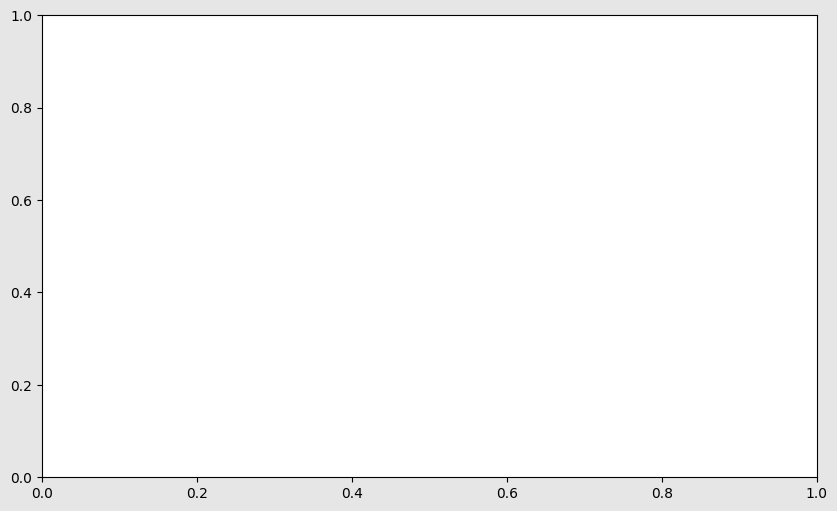

In [88]:
plot, var = pl.beta_plot_pc_granular(
        tables_dict=granular_tables['LSU'],
        metadata=full_metadata,
        table_name='Bacteria_class',
        taxon='env_material',
        factor='env_package')

In [87]:
# box_granular

In [ ]:
## Additional page to the app

# show indicator of the explained variance
explained_var_indicator2 = pn.indicators.Number(
    name='Explained variance by PC1 + PC2', value=0, format='{value:.1f}%',
    font_size='20pt',
    title_size='12pt',
    colors=[(33, 'red'), (50, 'gold'), (66, 'green')]
)

beta_pc_plot_granular = pn.pane.Matplotlib(
    sizing_mode="stretch_both",
    name="Beta PCoA",
    )

def update_beta_pc_plot_granular(tables_dict, metadata, table_name, taxon, factor):
    beta_pc_plot_granular.object, explained_var_indicator2.value = pl.beta_plot_pc_granular(
        tables_dict=tables_dict,
        metadata=metadata,
        table_name=table_name,
        taxon=taxon,
        factor=factor)
    

pn.bind(update_beta_pc_plot_granular,
    # tables_dict=select_granular_table.value,
    tables_dict=granular_tables[select_granular_table.value],
    metadata=full_metadata,
    table_name=select_granular_level,
    taxon=color_factor_granular,
    factor=symbol_factor_granular,
    watch=True,
    )

pcoa_tab_granular = pn.Column(
    box_granular,
    explained_var_indicator2,
    beta_pc_plot_granular,
)

## App setup

In [ ]:
pn.extension("tabulator")
if 'google.colab' in str(get_ipython()):
    pn.extension(comms='colab')
ACCENT = "teal"

styles = {
    "box-shadow": "rgba(50, 50, 93, 0.25) 0px 6px 12px -2px, rgba(0, 0, 0, 0.3) 0px 3px 7px -3px",
    "border-radius": "4px",
    "padding": "10px",
}

# TODO: there is a bug in the panel library that does not allow to open png files, renoming does not help 
image = pn.pane.JPG(os.path.join(assets_folder, "figs/metaGOflow_logo_italics.jpg"),
                    width=200,
                    height=100,
                    )

(select_table, select_cat_factor, 
 select_table_beta, select_taxon,
 select_beta_factor, beta_norm,
 ) = diversity_select_widgets(categorical_columns, numerical_columns)

progress_bar, indicator_usage = create_indicators_diversity()

def update_used_gb(event):
    if not event:
        return

    used_gb, total_gb = memory_load()
    progress_bar.value = int(used_gb / total_gb * 100)
    indicator_usage.value = used_gb

bplot_alpha = pn.bind(
    pl.alpha_plot,
    tables_dict=mgf_parquet_dfs,
    table_name=select_table,
    factor=select_cat_factor,
    metadata=full_metadata,
)

bplot_av_alpha = pn.bind(
    pl.av_alpha_plot,
    tables_dict=mgf_parquet_dfs,
    table_name=select_table,
    factor=select_cat_factor,
    metadata=full_metadata,
)

bplot_beta_heatmap = pn.bind(
    pl.beta_plot,
    tables_dict=mgf_parquet_dfs,
    table_name=select_table_beta,
    norm=beta_norm,
    taxon=select_taxon,
)

def update_beta_pc_plot(tables_dict, metadata, table_name, taxon, factor):
    beta_pc_plot.object, explained_var_indicator.value = pl.beta_plot_pc(
        tables_dict=tables_dict,
        metadata=metadata,
        table_name=table_name,
        taxon=taxon,
        factor=factor)

beta_pc_plot = pn.pane.Matplotlib(
    sizing_mode="stretch_both",
    name="Beta PCoA",
    )

pn.bind(update_beta_pc_plot,
    tables_dict=mgf_parquet_dfs,
    metadata=full_metadata,
    table_name=select_table_beta,
    taxon=select_taxon,
    factor=select_beta_factor,
    watch=True,
    )

# show indicator of the explained variance
explained_var_indicator = pn.indicators.Number(
    name='Explained variance by PC1 + PC2', value=0, format='{value:.1f}%',
    font_size='20pt',
    title_size='12pt',
    colors=[(33, 'red'), (50, 'gold'), (66, 'green')]
)

atable = pn.widgets.Tabulator(df, sizing_mode="stretch_both", name="Data View")

# assemble tab with the matrix and checkbox
heatmap_tab = pn.Column(
    beta_norm,
    bplot_beta_heatmap,
)

pcoa_tab = pn.Column(
    explained_var_indicator,
    beta_pc_plot,
)

tabs = pn.Tabs(
    ('Alpha div.', bplot_alpha),
    ('Av Aplpha div.', bplot_av_alpha),
    ('Beta div.', heatmap_tab),
    ('PCoA', pcoa_tab),
    ('PCoA granular', pcoa_tab_granular),
    atable,
    styles=styles, sizing_mode="stretch_both", margin=10
)

def app():
    cb = pn.state.add_periodic_callback(
        partial(update_used_gb, indicator_usage),
        period=1000,
        timeout=None,
        )
    cb2 = pn.state.add_periodic_callback(
        partial(update_used_gb, progress_bar),
        period=1000,
        timeout=None,
        )
    toggle = pn.widgets.Toggle(name='Toggle callback', value=True)
    toggle.link(cb, bidirectional=True, value='running')
    toggle.link(cb2, bidirectional=True, value='running')

    indicators = pn.FlexBox(
        progress_bar, indicator_usage, toggle)

    template = pn.template.FastListTemplate(
        title="Diversity Analysis",
        sidebar=[image,
                "# Alpha diversity", select_table, select_cat_factor,
                pn.layout.Divider(),
                "# Beta diversity", select_table_beta, select_taxon, select_beta_factor,
                pn.layout.Divider(),
                "# Beta granular", select_granular_table, select_granular_level,
                color_factor_granular, symbol_factor_granular,
                ],
        main=[pn.Column(indicators,
                        tabs,
                        sizing_mode="stretch_both",
                    )],
        main_layout=None,
        accent=ACCENT,
    )
    return template

template = app()

# stupid trick to trigger updata()
select_beta_factor.value = select_beta_factor.options[1]
select_beta_factor.value = select_beta_factor.options[0]

if 'google.colab' in str(get_ipython()):  
    s = serve_app(template, env=env, name="diversity_analysis")
else:
    template.servable()

### Uncomment this if running if running ngrok tunnel which you want to quit

In [ ]:
# only use for the ngrok tunnel in GColab
# close_server(s, env=env)